In [12]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import numpy as np
import cv2
import math
from operator import itemgetter
from dxfwrite import DXFEngine as dxf
from dxfwrite.dimlines import dimstyles, LinearDimension ,RadialDimension

In [13]:
#image name
name = 'test2.png'

In [14]:
minx=0
maxy=0

In [15]:
######functions

r=15 #how much do we want to approximate near points to be the same

def same(arr1,arr2):
    r=18
    if abs(arr1[0]-arr2[0])<r and abs(arr1[1]-arr2[1])<r and abs(arr1[2]-arr2[2])<r and abs(arr1[3]-arr2[3])<r:
        return True
    else :
        return False
    
def samep(n1,n2):
    r=15
    if abs(n1-n2)<r:
        return True
    else:
        return False
    
    
def im_in(n, array):
    r=15
    for i in array:
        if abs(n-i)<r:
            return True
        
    return False


def connect_vertical_lines(vertical_lines):
    maxy=0
    print('e3rd', vertical_lines)
    ShouldRemove = []
    vertical_end=[]
    for i in range(0,len(vertical_lines)):
        FlagOfRepetition = 0
        length = len(vertical_lines)
        maxy=0
        extention_flag=0
        
        for j in range(0,len(vertical_lines)):
            if(i==j):
                continue
                    
            if vertical_lines[i][0] == vertical_lines[j][0]:  # They have the same x #

                if vertical_lines[i][1] <= vertical_lines[j][1] and vertical_lines[i][3] >= vertical_lines[j][3]:  # i involve j #
                    #print(str(vertical_lines[i]) + " involve " + str(vertical_lines[j]),i)
                    ShouldRemove.append(vertical_lines[j])     # we should delete j

                elif vertical_lines[i][1] >= vertical_lines[j][1] and vertical_lines[i][3] <= vertical_lines[j][3]:  # j involve i #4
                    #print(str(vertical_lines[j]) + " involve " + str(vertical_lines[i]),i)
                    ShouldRemove.append(vertical_lines[i])    # we should delete i
                
                elif vertical_lines[i][1] <= vertical_lines[j][1] and vertical_lines[i][3] >= vertical_lines[j][1]:
                    extention_flag=1
                    print('case',vertical_lines[i],vertical_lines[j])
                    ShouldRemove.append(vertical_lines[j])
                    if vertical_lines[j][3]>=maxy:
                        maxy=vertical_lines[j][3]
                        
                        
        if extention_flag==1: 
            vertical_end.append((vertical_lines[i],maxy))
            print('appedned',vertical_lines[i],maxy)
                    
    output=[]                
    for i in range(len(vertical_lines)):
        flag=0
        for j in range(len(ShouldRemove)):
            if(vertical_lines[i][0]==ShouldRemove[j][0] and vertical_lines[i][1]==ShouldRemove[j][1] and
              vertical_lines[i][2]==ShouldRemove[j][2] and vertical_lines[i][3]==ShouldRemove[j][3]):
                flag=1
                break
                
        if(flag==0):
            print('3mlna append',len(vertical_end))
            for k in range(len(vertical_end)):
                print('elmafrood',vertical_lines[i],vertical_end[k][0])
                if(vertical_lines[i][0]==vertical_end[k][0][0] and vertical_lines[i][1]==vertical_end[k][0][1] and
                  vertical_lines[i][2]==vertical_end[k][0][2] and vertical_lines[i][3]==vertical_end[k][0][3]):
                    vertical_lines[i][3]=vertical_end[k][1]
                    print('fe3ly',i,vertical_end[k][1])
            output.append(vertical_lines[i])

    return output
            
def connect_horizontal_lines(horizontal_lines):
    ShouldRemove = []
    for i in range(0,len(horizontal_lines)):
        FlagOfRepetition = 0
        length = len(horizontal_lines)
        for j in range(0,len(horizontal_lines)):
            
            if(i==j):
                continue

            if horizontal_lines[i][1] == horizontal_lines[j][1]:  # They have the same x #

                if horizontal_lines[i][0] <= horizontal_lines[j][0] and horizontal_lines[i][2] >= horizontal_lines[j][2]:  # i involve j #
                    #print(str(vertical_lines[i]) + " involve " + str(vertical_lines[j]),i)
                    ShouldRemove.append(horizontal_lines[j])     # we should delete j

                elif horizontal_lines[i][0] >= horizontal_lines[j][0] and horizontal_lines[i][2] <= horizontal_lines[j][2]:  # j involve i #4
                    #print(str(vertical_lines[j]) + " involve " + str(vertical_lines[i]),i)
                    ShouldRemove.append(horizontal_lines[i])    # we should delete i
                    
                elif horizontal_lines[i][0] <= horizontal_lines[j][0] and horizontal_lines[i][2] >= horizontal_lines[j][0]:
                    ShouldRemove.append(horizontal_lines[j])
                    horizontal_lines[i][2]=horizontal_lines[j][2]
                    
                    
    output=[]                
    for i in range(len(horizontal_lines)):
        flag=0
        for j in range(len(ShouldRemove)):
            if(horizontal_lines[i][0]==ShouldRemove[j][0] and horizontal_lines[i][1]==ShouldRemove[j][1] and
              horizontal_lines[i][2]==ShouldRemove[j][2] and horizontal_lines[i][3]==ShouldRemove[j][3]):
                flag=1
                break
                
        if(flag==0):
            output.append(horizontal_lines[i])

    return output


    
############################################ FUNCTION DETECT LINES
def detect_lines(gray):
    global  horizontal
    global vertical
    global general_line
    global minx
    global maxy
    
    #creating a corresponding white image
    
    white = np.zeros_like(gray)                                                       
    white.fill(255)
    pure_lines = white
    
    
    #detect edge
    #di = cv2.dilate(gray,cv2.getStructuringElement(cv2.MORPH_RECT,(7,7)),iterations = 1)
    #edges=di-gray
    edges = cv2.Canny(gray, 50, 100)                           # get the edges

    #convert to binary image
    ret,edges = cv2.threshold(edges,40,255,cv2.THRESH_BINARY)



    kernel=cv2.getStructuringElement(cv2.MORPH_RECT,(7,7))
    edges = cv2.morphologyEx(edges,cv2.MORPH_CLOSE,kernel)

    #edges = cv2.dilate(edges,cv2.getStructuringElement(cv2.MORPH_RECT,(3,3)),iterations = 1)
    print('edges before houghlines')
    plt.imshow(edges, cmap='gray')
    plt.show()
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, 80, minLineLength=0, maxLineGap=0)       # Detect lines


    ####################################################################################################################

    new_lines=[]
    try:
        for i in range(len(lines)):
            flag=0
            if (i!=0):
                for j in range(i):
                        if same(lines[i][0],lines[j][0]):
                            flag=1
                            continue
            if(flag==0):
                line=[]
                line.append(lines[i][0][0])
                line.append(lines[i][0][1])
                line.append(lines[i][0][2])
                line.append(lines[i][0][3])
                new_lines.append(line)
    
    except:
        print('no lines found')
        return pure_lines
    
    xs=[]
    ys=[]

    for i in new_lines:
        xs.append(i[0])
        xs.append(i[2])
        ys.append(i[1])
        ys.append(i[3])

    # sorting #
    sorted_x=sorted(xs)
    sorted_y=sorted(ys)


    special_x=[]
    special_y=[]


    for i in sorted_x:
        if not(im_in(i, special_x)):
            special_x.append(i)

    for i in sorted_y:
        if not(im_in(i, special_y)):
            special_y.append(i)

    print(special_x,'yes')


    ######################################################################################################################

    for i in range(len(new_lines)):
        for j in range(len(special_x)):
            if(abs(new_lines[i][0]-special_x[j])<r):
                new_lines[i][0]=special_x[j]
                break

        for j in range(len(special_x)):
            if(abs(new_lines[i][2]-special_x[j])<r):
                new_lines[i][2]=special_x[j]
                break
        for j in range(len(special_y)):
            if(abs(new_lines[i][1]-special_y[j])<r):
                new_lines[i][1]=special_y[j]
                break

        for j in range(len(special_y)):
            if(abs(new_lines[i][3]-special_y[j])<r):
                new_lines[i][3]=special_y[j]
                break        


    for i in range(len(new_lines)):   
        x1, y1, x2, y2 = new_lines[i]
        cv2.line(white, (x1, y1), (x2, y2), (0, 0, 0), 3)
    #x1, y1, x2, y2 = new_lines[8]
    #cv2.line(white, (x1, y1), (x2, y2), (255, 0, 0), 3)
    for i in new_lines:
        print(i,'here')

    print('after detecting lines')   
    plt.imshow(white)
    plt.show()

    pure_lines = white


    #FOR FARAG's HAPPINESS  ( Thank You ^^ )
    # Getting the start point #
    minx=min(special_x)
    maxy=max(special_y)

    print(new_lines, 'all lines')
    
    
    
    for i in range(len(new_lines)):
        
        
        new_lines[i][0]-=minx
        new_lines[i][2]-=minx

        new_lines[i][1]=maxy-new_lines[i][1]
        new_lines[i][3]=maxy-new_lines[i][3]



    vertical=[]
    horizontal=[]
    general_line=[]
    
    vertical_1=[]
    horizontal_1=[]
    general_line_1=[]
    
    for i in new_lines:
        i.append(math.sqrt((i[0]-i[2])**2+(i[1]-i[3])**2))
        if i[0]==i[2]:                  # To Extract Vertical lines
            vertical_1.append(i)
        elif i[1]==i[3]:
            horizontal_1.append(i)        # To Extract Horizontal lines
        else:
            general_line_1.append(i)      # To Extract General lines

    vertical_1=connect_vertical_lines(vertical_1)        # ( Connect Vertical lines first ) #
    print("ssdsafsdaf",vertical_1)
    horizontal_1=connect_horizontal_lines(horizontal_1)
    

    for i in vertical_1:
        vertical.append(i)

    for i in horizontal_1:
        horizontal.append(i)

        
    for i in general_line_1:
        general_line.append(i)
    
    return pure_lines
    #horizontal = np.array(horizontal)
    #vertical = np.array(vertical_2)

    # print("H",horizontal,"H")
    # print("V",vertical,"V")
    # print("G",general_line,"G")
    # Show result     


edges before houghlines


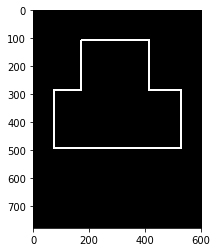

[72, 169, 410, 525] yes
[72, 490, 525, 490] here
[169, 107, 410, 107] here
[72, 490, 72, 281] here
[525, 490, 525, 281] here
[410, 281, 525, 281] here
[72, 281, 169, 281] here
[410, 281, 410, 107] here
[169, 281, 169, 107] here
[72, 443, 72, 281] here
[410, 131, 410, 180] here
[72, 490, 72, 330] here
[72, 386, 72, 330] here
[410, 281, 410, 164] here
after detecting lines


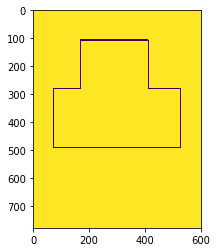

[[72, 490, 525, 490], [169, 107, 410, 107], [72, 490, 72, 281], [525, 490, 525, 281], [410, 281, 525, 281], [72, 281, 169, 281], [410, 281, 410, 107], [169, 281, 169, 107], [72, 443, 72, 281], [410, 131, 410, 180], [72, 490, 72, 330], [72, 386, 72, 330], [410, 281, 410, 164]] all lines
e3rd [[0, 0, 0, 209, 209.0], [453, 0, 453, 209, 209.0], [338, 209, 338, 383, 174.0], [97, 209, 97, 383, 174.0], [0, 47, 0, 209, 162.0], [338, 359, 338, 310, 49.0], [0, 0, 0, 160, 160.0], [0, 104, 0, 160, 56.0], [338, 209, 338, 326, 117.0]]
case [0, 0, 0, 160, 160.0] [0, 47, 0, 209, 162.0]
appedned [0, 0, 0, 160, 160.0] 209
3mlna append 1
elmafrood [0, 0, 0, 209, 209.0] [0, 0, 0, 160, 160.0]
3mlna append 1
elmafrood [453, 0, 453, 209, 209.0] [0, 0, 0, 160, 160.0]
3mlna append 1
elmafrood [338, 209, 338, 383, 174.0] [0, 0, 0, 160, 160.0]
3mlna append 1
elmafrood [97, 209, 97, 383, 174.0] [0, 0, 0, 160, 160.0]
ssdsafsdaf [[0, 0, 0, 209, 209.0], [453, 0, 453, 209, 209.0], [338, 209, 338, 383, 174.0], [97, 20

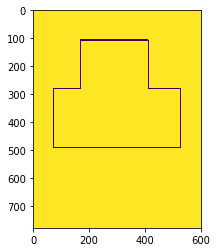

######################################################2 

test


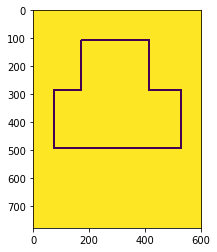

lines after dilation


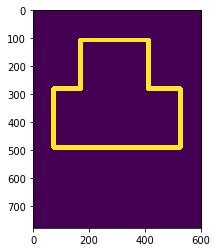

output circles only to be detected


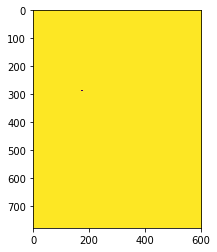

######################################################3 

######################################################4 

a circle to be detected


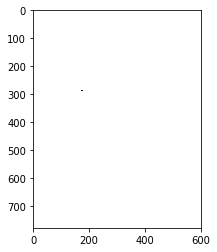

None
except
None
except again
list []
gray without lines


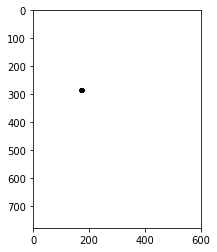

In [16]:
test = cv2.imread(name)     # Reading the original image


gray = cv2.cvtColor(test, cv2.COLOR_BGR2GRAY)                # convert fron BGR to Gray


horizontal=[]
vertical=[]
general_line=[]
        
pure_lines = detect_lines(gray)

print('NOWWWWWW')
plt.imshow(pure_lines)
plt.show()

# vertical, horizontal ,general_line, pure_lines = detect_lines(pure_lines, white)

# print('NOWWWWWW')
# plt.imshow(pure_lines)
# plt.show()



##################################################################################################################

print('######################################################2 \n')
test = cv2.cvtColor(test, cv2.COLOR_BGR2GRAY)                # convert fron BGR to Gray


test = cv2.Canny(test, 100, 150)                           # get the edges

#convert to binary image
ret,test = cv2.threshold(test,40,255,cv2.THRESH_BINARY)

test = cv2.dilate(test,cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7)),iterations = 1)
test = cv2.erode(test,cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7)),iterations = 1)   
#ret,test = cv2.threshold(test,70,255,cv2.THRESH_BINARY)

test=cv2.bitwise_not(test)





ret,pure_lines = cv2.threshold(pure_lines,40,255,cv2.THRESH_BINARY)

white2=cv2.bitwise_not(pure_lines)

print('test')
plt.imshow(test)
plt.show()

print('lines after dilation')
white2 = cv2.dilate(white2,cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(13,13)),iterations = 1)
plt.imshow(white2)
plt.show()

#white2 = cv2.erode(white2,cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(9,9)),iterations = 1)


only_lines=cv2.bitwise_not(white2)


test=cv2.bitwise_not(test)
output=cv2.subtract(test,white2)
test=cv2.bitwise_not(test)

output = cv2.dilate(output,cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7)),iterations = 1)

output=cv2.bitwise_not(output)

print('output circles only to be detected')
plt.imshow(output)
plt.show()


print('######################################################3 \n')
def det_circles(img,deep=0):
    
    
    img = cv2.medianBlur(img,5)

    circles=[]
    if deep==0:
        try:
            circles = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT,
                    1,60,param1=50, param2=30, minRadius=0,maxRadius=0)
            circles = np.uint16(np.around(circles))
        except:
            pass
    else:
        try:
            circles = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT,
                    1,60,param1=30, param2=15, minRadius=0,maxRadius=0)
            circles = np.uint16(np.around(circles))
        except:
            pass
    return circles



    
print('######################################################4 \n')
list_circles=[]
kernal=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(9,9))




#output=cv2.imread('circles1.png')


only_circles = output
deep=0 #the last iteration try to find circles more deeply

while(1):
    
    gray = output
    
    print('a circle to be detected')
    plt.imshow(gray,cmap='gray')
    plt.show()
    
    circles=det_circles(gray,deep)
    print(circles)
    
    #deep=0 #deep = 0 again to check if it one a
        
    try:
        if(len(circles)==0  or circles[0][0][2]==0):
            print('try')
            break
    except:
        deep=1
        print('except')
        
    
    if(deep==1): #try to deep search for circles
        circles=det_circles(gray,deep)
        print(circles)
        
        try:
            if(len(circles)==0  or circles[0][0][2]==0):
                print('try')
                break
        except:
            deep=1
            print('except again')
            break
        #continue
    
    print('circles after break', circles)
    for i in circles[0]:
        print('iiiiiiiiiiii',i)
        
        circle=[]
        circle.append(i[0])
        circle.append(i[1])
        circle.append(i[2])
        
        list_circles.append(circle)
        
    #creating a corresponding white image
    white_new = np.zeros_like(test)                                                       
    white_new.fill(255)
    
    for i in circles[0,:4]:
        print('style',i[0],i[1],i[2])
        cv2.circle(white_new,(i[0],i[1]),i[2],(0,0,0),2)

    test=cv2.bitwise_not(output)
    white2=cv2.bitwise_not(white_new)
    
    test = cv2.erode(test,cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)),iterations = 1)
    white2 = cv2.dilate(white2,cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(19,19)),iterations = 1)
    
    output = cv2.subtract(test , white2)
    
    print('this')
    plt.imshow(test)
    plt.show()
    
    print('minus this')
    plt.imshow(white2)
    plt.show()
    
    
    plt.imshow(output)
    plt.show()
    
    
    output = cv2.dilate(output,cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)),iterations = 1)
    
    output=cv2.bitwise_not(output)
    
    print('after removing the first circle')


# output = cv2.cvtColor(output, cv2.COLOR_BGR2GRAY)
# ret,output = cv2.threshold(output,100,255,cv2.THRESH_BINARY)

# plt.imshow(output, cmap='gray')
# plt.show()

# circles2=det_circles(output)
# print('2222',circles2)
# list_circles.append(circles2)


print('list', list_circles)


        
        

    
    
    
#gray = cv2.imread(name,0)
#only_lines = cv2.cvtColor(only_lines, cv2.COLOR_BGR2GRAY)                # convert fron BGR to Gray
#ret,gray = cv2.threshold(gray,40,255,cv2.THRESH_BINARY)
#ret,only_lines = cv2.threshold(only_lines,40,255,cv2.THRESH_BINARY)

#make the lines thinner
#only_lines = cv2.dilate(only_lines,cv2.getStructuringElement(cv2.MORPH_RECT,(5,5)),iterations = 1)

#print('shape gray', gray.shape)
#print('only_lines gray', only_lines.shape)


#plt.imshow(gray,cmap='gray')
#plt.show()

#plt.imshow(only_lines,cmap='gray')
#plt.show()


#gray=cv2.subtract(only_lines, gray)
#gray = cv2.dilate(gray,cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(21,21)),iterations = 1)

gray = only_circles                # convert fron BGR to Gray
gray = cv2.erode(gray,cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(17,17)),iterations = 1)

print('gray without lines')
plt.imshow(gray,cmap='gray')
plt.show()
#gray=cv2.bitwise_not(gray)

for j in range(len(list_circles)):
    
    print('circle number', j)
    Find_Right_point = 0
    Find_Left_point = 0
    Find_Up_point = 0
    Find_Down_point = 0
    
    x = list_circles[j][0]
    y = list_circles[j][1]
    r = list_circles[j][2] 
    
    black = 200 #if the pixel value is less than this,, consider it black
    
    for i in range (0,12):
        for k in range(25):
            index = x +r-5+i
            value_1 = gray[y+k][index]
            value_2 = gray[y-k][index]
            #print('right',value_1,value_2,h)
            if (black > value_1 or black > value_2) and Find_Right_point == 0 :
                Find_Right_point = 1
                print('Find_Right_point')

            index = x - r - 5 + i
            value_1 = gray[y+k][index]
            value_2 = gray[y-k][index]
            #print('left',value_1,value_2,h)
            if (black > value_1 or black > value_2) and Find_Left_point == 0:
                Find_Left_point = 1
                print('Find_Left_point')

            index = y+r-5+i
            value_1 = gray[index][x-k]
            value_2 = gray[index][x+k]
            #print('down',value_1,value_2,h)
            if  (black > value_1 or black > value_2) and Find_Down_point == 0:
                Find_Down_point = 1
                print('Find_Down_point')

            index = y - r - 5 + i
            value_1 = gray[index][x-k]
            value_2 = gray[index][x+k]
            #print('up',value_1,value_2)
            if (black > value_1 or black > value_2) and Find_Up_point == 0 :
                Find_Up_point = 1
                print('Find_Up_point')

    Decision = str(Find_Right_point)+str(Find_Left_point)+str(Find_Up_point)+str(Find_Down_point)
    #print(Decision)
    if Decision == '1011':
        list_circles[j].append('right half circle')
    elif Decision == '0111':
        list_circles[j].append('left half circle')
    elif Decision == '1110':
        list_circles[j].append('up half circle')
    elif Decision == '1101':
        list_circles[j].append('down half circle')
    else:
        #print(Decision)
        list_circles[j].append('full circle')

            
            
for j in list_circles:
    #for i in range(3):
    # #Getting The Centre
    # x = i[0]
    # y = i[1]
    #
    # #Getting The Radius
    # r = i[2]
    #draw the outer circle
    #cv2.circle(white,(j[0],j[1]),j[2],(0,0,0),2)
    #draw the center of the circle
    #cv2.circle(white,(i[0],i[1]),2,(0,0,255),3)
    print (j[2])

    
    
for j in range(len(list_circles)):
    list_circles[j][0] -= minx
    list_circles[j][1]  = maxy-list_circles[j][1]

    
#plt.imshow(white,cmap='gray')




In [17]:
# vertical=sorted(vertical, key = itemgetter(4))

# print(vertical)

In [18]:
# Number of colors #
Red=1
Yellow=2
Green=3
Labny=4
Blue=5
Foshia=6
White=7
theta=0

     

class shapes:
    

    drawing = ''

    def __init__(self,fileName):
        self.drawing = dxf.drawing(fileName + '.dxf')



    def text(self,text,x,y,color = Foshia):
        text = dxf.text(text, (x, y), height=0.3, rotation=0)
        text['layer'] = 'TEXT'
        text['color'] = color
        self.drawing.add(text)
        self.drawing.save()

    def line_with_NO_dims(self,x1, y1, x2, y2,color = White):
        line = dxf.line((x1, y1), (x2, y2))
        line['color'] = color
        self.drawing.add(line)
        self.drawing.save()

    def Horizontal_line_with_under_dims(self,x1, y1, x2, y2,length,color = White):
        line = dxf.line((x1, y1), (x2, y2))
        line['color'] = color
        self.drawing.add(line)

        dimstyles.setup(self.drawing)

        points = [(x1, y1 + 0.3), (x2, y1 + 0.3)]  # mn hna bt7dd x bta3 al point   # al y = height of blue line

        dimstyles.new("arrow", tick="DIMTICK_ARROW",height=0.2, tick2x=True, dimlineext=0.)

        # The angle control the slope of line
        Theta = math.atan((y1 - y2) / (x1 - x2))
        Theta = math.degrees(Theta)
        self.drawing.add(
            LinearDimension((10, y1 - length/300), points, dimstyle='arrow', angle=Theta))  # mn hna bt7dd y bta3 al point
        # drawing.set_text(1, 'CATCH')
        self.drawing.save()

    def Horizontal_line_with_upper_dims(self,x1, y1, x2, y2,length,color = White):
        line = dxf.line((x1, y1), (x2, y2))
        line['color'] = color
        self.drawing.add(line)

        dimstyles.setup(self.drawing)

        points = [(x1, y1 ), (x2, y1 )]  # mn hna bt7dd x bta3 al point   # al y = height of blue line

        dimstyles.new("arrow", tick="DIMTICK_ARROW",height=0.2, tick2x=True, dimlineext=0.)

        # The angle control the slope of line
        Theta = math.atan((y1 - y2) / (x1 - x2))
        Theta = math.degrees(Theta)
        self.drawing.add(
            LinearDimension((10, y1 + 0.5), points, dimstyle='arrow', angle=Theta))  # mn hna bt7dd y bta3 al point
        # drawing.set_text(1, 'CATCH')
        self.drawing.save()

    def vertical_line_with_left_dims(self,x1, y1, x2, y2,length,color = White):
        line = dxf.line((x1, y1), (x2, y2))
        line['color'] = color
        self.drawing.add(line)

        dimstyles.setup(self.drawing)

        points = [(x1 + 0.3 , y1), (x1 + 0.3, y2)]  # mn hna bt7dd y bta3 al point   # al x = height of blue line

        dimstyles.new("arrow", tick="DIMTICK_ARROW",height=0.2, tick2x=True, dimlineext=0.)


        self.drawing.add(
            LinearDimension((x1 - 1 , 7), points, dimstyle='arrow', angle=90))  # mn hna bt7dd x bta3 al point

        self.drawing.save()

    def vertical_line_with_right_dims(self,x1, y1, x2, y2,length,color = White):
        line = dxf.line((x1, y1), (x2, y2))
        line['color'] = color
        self.drawing.add(line)

        dimstyles.setup(self.drawing)

        points = [(x1-0.3 , y1), (x1-0.3 , y2)]  # mn hna bt7dd y bta3 al point   # al x = height of blue line

        dimstyles.new("arrow", tick="DIMTICK_ARROW",height=0.2, tick2x=True, dimlineext=0.)


        self.drawing.add(
            LinearDimension((x1 + length/300 , 7), points, dimstyle='arrow', angle=90))  # mn hna bt7dd x bta3 al point

        self.drawing.save()

    def circle_with_NO_dims(self, r, x, y,color = White):
        circle = dxf.circle(r, (x, y))
        circle['color'] = color
        self.drawing.add(circle)

        self.drawing.save()

    def circle_with_dims(self,r, x, y,color = White):
        global theta
        
        circle = dxf.circle(r, (x, y))
        circle['color'] = color
        self.drawing.add(circle)

        dimstyles.setup(self.drawing)
        dimstyles.new("radius", height=0.2, prefix='R=')

        self.drawing.add(RadialDimension((x, y), (x+r*np.sin(theta), y + r*np.cos(theta)), dimstyle='radius'))
        self.drawing.save()
        theta=(theta+0.6)%6

    def arc(self,r,x,y,Theta1,Theta2,color = White):
        arc = dxf.arc(r, (x, y), Theta1, Theta2)
        arc['color'] = color
        self.drawing.add(arc)
        self.drawing.save()

    def rectangle(self,x,y,width,height,color = White):
        # (x,y) is the top right point of the rectangle

        s.line_with_NO_dims(x-width, y-height, x, y-height,color)
        s.line_with_NO_dims(x, y-height, x, y,color)
        s.line_with_NO_dims(x-width, y-height, x-width, y,color)
        s.line_with_NO_dims(x-width, y, x, y,color)

    def dashed_line(self,x1,y1,x2,y2,color = Red):  # The dashed line should be vertical or horizontal only
        if x1 == x2:                            # vertical dashed line
            array = np.arange(y1, y2, 0.001)
            count = 0
            for y in array:
                if count <= 100:
                    point = dxf.point((x1,y))
                    point['color'] = color
                    self.drawing.add(point)
                    count = count + 1
                else:
                    if count == 160:
                        count = 0
                    else:
                        count = count + 1

        elif y1 == y2:                          # Horizontal dashed line
            array = np.arange(x1, x2, 0.001)
            count = 0
            for x in array:
                if count <= 100:
                    point = dxf.point((x, y1))
                    point['color'] = color
                    self.drawing.add(point)
                    count = count + 1
                else:
                    if count == 160:
                        count = 0
                    else:
                        count = count + 1
        self.drawing.save()
        
    def Determine_UpperOrUnder(self,y,index,facator):
        Flag_there_is_a_line_above_me = 0
        #print("y",y)
        for i in horizontal:
            print("i[1]",i[1])
            if  i[1] > y:
                Flag_there_is_a_line_above_me = 1
                break
        
        #print("Flag",Flag_there_is_a_line_above_me)
        if Flag_there_is_a_line_above_me == 0:        
            self.Horizontal_line_with_upper_dims(horizontal[index][0]/factor, horizontal[index][1]/factor,
                       horizontal[index][2]/factor, horizontal[index][3]/factor,horizontal[index][4],Green)
        else:
            self.Horizontal_line_with_under_dims(horizontal[index][0]/factor, horizontal[index][1]/factor,
                           horizontal[index][2]/factor, horizontal[index][3]/factor,horizontal[index][4],Green)
                
    def Determine_RightOrLeft(self,x,index,facator):
        Flag_there_is_a_line_right_me = 0
        
        for i in vertical:
            if  i[0] > x:
                Flag_there_is_a_line_right_me = 1
                break
               
        if Flag_there_is_a_line_right_me == 0:        
            self.vertical_line_with_right_dims(vertical[index][0]/factor, vertical[index][1]/factor,
                       vertical[index][2]/factor, vertical[index][3]/factor,vertical[index][4],Green)
        else:
            self.vertical_line_with_left_dims(vertical[index][0]/factor, vertical[index][1]/factor,
                           vertical[index][2]/factor, vertical[index][3]/factor,vertical[index][4],Green)
                
            





# This main is only for Testing #
if __name__ == '__main__':
    s = shapes(name)
    #s.circle_with_dims(2,3,5,Blue)


     #Ex1: Tesing all shpes I have till Now #

    # s.line_with_NO_dims(1,1,2,2)
    # s.Horizontal_line_with_under_dims(2,3,5,3)
    # s.Horizontal_line_with_upper_dims(2,5,5,5)
    # s.vertical_line_with_left_dims(10,2,10,8,Blue)
    # s.vertical_line_with_right_dims(13,2,13,8)
    # s.circle_with_NO_dims(2,17,6.5,Yellow)
    # s.circle_with_dims(2,17,2)
    # s.arc(1.2,5.6,2.4,30.5,90.9)




     #EX2: trying to draw the proposal shape #
    
    factor = 50
    # s.text("Elevation",6.7,-0.5)
    #[[57, 58, 318, 58, 261.0], [57, 145, 318, 145, 261.0], [0, 0, 385, 0, 385.0]]
    horizontal=sorted(horizontal, key = itemgetter(4))    # sortred by length
 #  HORIZONTAL=sorted(HORIZONTAL, key = itemgetter(1))    # sorted by ( y )
    
    
    if(len(horizontal)==1):
        s.Horizontal_line_with_under_dims(horizontal[0][0]/factor, horizontal[0][1]/factor, horizontal[0][2]/factor, horizontal[0][3]/factor,horizontal[0][4],Green)
    
    if(len(horizontal)>1 and (horizontal[0][4]!=horizontal[1][4])):
        s.Determine_UpperOrUnder(horizontal[0][1],0,factor)
    
    for i in range (1,len(horizontal)):
        
        if(horizontal[i][4]==horizontal[i-1][4]):    # length of i = length of  i-1 
            if(horizontal[i][1]<horizontal[i-1][1]): #  i under i-1 
                s.Horizontal_line_with_under_dims(horizontal[i][0]/factor, horizontal[i][1]/factor, horizontal[i][2]/factor, horizontal[i][3]/factor,horizontal[i][4],Green)
                s.line_with_NO_dims(horizontal[i-1][0]/factor, horizontal[i-1][1]/factor, horizontal[i-1][2]/factor, horizontal[i-1][3]/factor,Green)
            else:                                    # i upper i-1
                s.line_with_NO_dims(horizontal[i][0]/factor, horizontal[i][1]/factor, horizontal[i][2]/factor, horizontal[i][3]/factor,Green)
                s.Horizontal_line_with_under_dims(horizontal[i-1][0]/factor, horizontal[i-1][1]/factor, horizontal[i-1][2]/factor, horizontal[i-1][3]/factor,horizontal[i-1][4],Green)
        elif(i==len(horizontal)-1):
             s.Determine_UpperOrUnder(horizontal[i][1],i,factor)
            
        elif(horizontal[i][4]!=horizontal[i-1][4] and horizontal[i][4]!=horizontal[i+1][4]):
            s.Determine_UpperOrUnder(horizontal[i][1],i,factor)
    
    
    
    vertical=sorted(vertical, key = itemgetter(4))
    
    if(len(vertical)==1):
        s.vertical_line_with_right_dims(vertical[0][0]/factor, vertical[0][1]/factor, vertical[0][2]/factor, vertical[0][3]/factor,vertical[0][4],Green)
    if(len(vertical)>1 and (vertical[0][4]!=vertical[1][4])):
        s.Determine_RightOrLeft(vertical[0][0],0,factor)
        
    for i in range (1,len(vertical)):
        if(vertical[i][4]==vertical[i-1][4]):     # length of i = length of  i-1 
            if(vertical[i][0]>vertical[i-1][0]):  #  i right i-1  
                s.vertical_line_with_right_dims(vertical[i][0]/factor, vertical[i][1]/factor, vertical[i][2]/factor, vertical[i][3]/factor,vertical[i][4],Green)
                s.line_with_NO_dims(vertical[i-1][0]/factor, vertical[i-1][1]/factor, vertical[i-1][2]/factor, vertical[i-1][3]/factor,Green)
            else:
                s.line_with_NO_dims(vertical[i][0]/factor, vertical[i][1]/factor, vertical[i][2]/factor, vertical[i][3]/factor,Green)
                s.vertical_line_with_right_dims(vertical[i-1][0]/factor, vertical[i-1][1]/factor, vertical[i-1][2]/factor, vertical[i-1][3]/factor,vertical[i-1][4],Green)
        elif(i==len(vertical)-1):
            s.Determine_RightOrLeft(vertical[i][0],i,factor)
            
        elif(vertical[i][4]!=vertical[i-1][4] and vertical[i][4]!=vertical[i+1][4]):
             s.Determine_RightOrLeft(vertical[i][0],i,factor)
            
    
    for i in general_line:
        s.line_with_NO_dims(i[0]/factor, i[1]/factor, i[2]/factor, i[3]/factor,Green)
    for i in vertical:
        s.line_with_NO_dims(i[0]/factor, i[1]/factor, i[2]/factor, i[3]/factor,Green)
    for i in horizontal:
        s.line_with_NO_dims(i[0]/factor, i[1]/factor, i[2]/factor, i[3]/factor,Green)
    
    
    
          
    print(vertical)
        
    print(horizontal)
    for j in list_circles:
        if j[3]=='full circle':
            s.circle_with_dims(j[2]/factor, j[0]/factor, j[1]/factor,Green)
            print ('full', j[2]/factor)
            
        elif j[3]=='up half circle':
            s.arc(j[2]/factor, j[0]/factor, j[1]/factor, 0,180,Green)
            print ('up', j[2]/factor)

        elif j[3]=='down half circle':
            s.arc(j[2]/factor, j[0]/factor, j[1]/factor, 180,0,Green)
            print ('down', j[2]/factor)
            
        elif j[3]=='left half circle':
            s.arc(j[2]/factor, j[0]/factor, j[1]/factor, 90,270,Green)
            print ('left', j[2]/factor)
            
        elif j[3]=='right half circle':
            s.arc(j[2]/factor, j[0]/factor, j[1]/factor, 270,90,Green)
            print ('right', j[2]/factor)

    #s.Horizontal_line_with_under_dims( 0, 21.2, 45.5, 21.2)
    #s.vertical_line_with_right_dims( 0,   0,   0, 21.2)
    #s.vertical_line_with_left_dims(45.5,   0, 45.5, 21.2)
    #
    #
    #
    # s.rectangle(9.5,3,4,1)
    # s.arc(2.5,7.5,6,0,180)
    #
    # s.circle_with_NO_dims(1.5,7.5,6)


     #EX3: trying to detect circles
    #s.circle_with_NO_dims(2, 2, 2)        # 1
    #s.circle_with_NO_dims(2,7.5 ,2 )      # 2
    #s.circle_with_dims(1.5, 7.5, 6)       # 3
    #s.circle_with_NO_dims(1, 2, 6)        # 4
print('done')

i[1] 209
i[1] 209
i[1] 383


PermissionError: [Errno 13] Permission denied: 'test2.png.dxf'